# Union de archivo de velocidades del plan maestro de movilidad

Se agregan las velocidades del plan maestro de movilidad para aumentar los datos

## Necesarios
* Base de datos de velocidades en excel
* Base de datos de velocidades
* Librerias necesarias instaladas

In [1]:
# Tratamiento de datos
# ==============================================================================
import gpxpy 
import gpxpy.gpx
import pandas as pd
import numpy as np
import geopandas as gpd
import math as mt

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime, time, date
from os import listdir
import os
import re
from shapely.geometry import Point, LineString
from shapely import wkt

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Se carga el archivo de excel que contienelas celdas tener en cuenta de hacer coinsidir el nombre
#de las columnas que mas se puedan para asi hacer un mejor uso de los datos
archcarro = 'G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/carro.xlsx'
archmoto = 'G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/Moto.xlsx'
archTPC = 'G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/TPC.xlsx'

dfcar = pd.read_excel(archcarro, sheet_name='Hoja1')
dfmot = pd.read_excel(archmoto, sheet_name='Hoja1')
dfTPC = pd.read_excel(archTPC, sheet_name='Hoja1')

print(dfcar.head(2))
print(dfmot.head(2))
print(dfTPC.head(2))

  file  ID  altura  velocity_m  velocity_k           timestamp  latitud  \
0   EO   3    1010     2.22222     8.00000 2017-06-20 06:38:43  4.45837   
1   EO   4     966     3.88889    14.00000 2017-06-20 06:38:58  4.45807   

   longitud      fecha        t0    tiempo  
0 -75.12582 2017-06-20  06:00:00  06:38:43  
1 -75.12577 2017-06-20  06:00:00  06:38:58  
  file  ID  altura  velocity_m  velocity_k           timestamp  latitud  \
0   EO  27     911     1.66667     6.00000 2017-06-22 07:45:05  4.45717   
1   EO  28     910     3.61111    13.00000 2017-06-22 07:45:07  4.45717   

   longitud      fecha        t0    tiempo  
0 -75.12560 2017-06-22  07:00:00  07:45:05  
1 -75.12563 2017-06-22  07:00:00  07:45:07  
   file  ID  altura  velocity_m  velocity_k           timestamp  latitud  \
0     1   1    1324     5.55556    20.00000 2017-06-16 09:11:55  4.45272   
1     1   2    1325     5.00000    18.00000 2017-06-16 09:12:02  4.45293   

   longitud    tiempo  
0 -75.24493  09:11:55  
1

In [3]:
#Se llaman los datos de velocidad obtenidos en el GPX
velcar = gpd.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/Carro.shp")
velmot = gpd.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/Moto.shp")
velTPC = gpd.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/TPC.shp")

print(velcar.head(2))
print(velmot.head(2))
print(velTPC.head(2))

   ID  latitud  longitud     altura       fecha    tiempo  \
0   1  4.43089 -75.24018 1217.72900  11-09-2020  12:25:01   
1   2  4.43089 -75.24017 1217.56100  11-09-2020  12:25:02   

             timestamp                            file        t0         A0  \
0  2020-09-11 12:25:01  2020-09-11_07-25_Fri CARRO.gpx  12:25:01 1217.72900   
1  2020-09-11 12:25:02  2020-09-11_07-25_Fri CARRO.gpx  12:25:01 1217.72900   

   velocity_m  velocity_k     slope                       geometry  
0     0.00000     0.00000   0.00000  POINT (870947.965 981821.229)  
1     0.20794     0.74860 -80.79070  POINT (870947.887 981821.168)  
   ID  latitud  longitud     altura       fecha    tiempo  \
0   1  4.40523 -75.16315 1029.02100  09-09-2020  17:09:58   
1   2  4.40523 -75.16315 1029.05400  09-09-2020  17:09:59   

             timestamp                           file        t0         A0  \
0  2020-09-09 17:09:58  2020-09-09_12-09_Wed moto.gpx  17:09:58 1029.02100   
1  2020-09-09 17:09:59  2020-09

## Carro

In [4]:
#Para obterner el geometry de estas velocidades en excel se localizan segun las coordenadas
gdfcar = gpd.GeoDataFrame(
    dfcar, geometry=gpd.points_from_xy(dfcar.longitud, dfcar.latitud),crs={"init":"EPSG:4326"})

In [5]:
#Se convierte el formato a magna sirgas bogota
gdfcar = gdfcar.to_crs({"init":"EPSG:3116"})

In [6]:
#Se visualizan los datos para entender mejor
gdfcar.head(2)

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,fecha,t0,tiempo,geometry
0,EO,3,1010,2.22222,8.00000,2017-06-20 06:38:43,4.45837,-75.12582,2017-06-20,06:00:00,06:38:43,POINT (883647.110 984840.929)
1,EO,4,966,3.88889,14.00000,2017-06-20 06:38:58,4.45807,-75.12577,2017-06-20,06:00:00,06:38:58,POINT (883652.613 984807.741)


<AxesSubplot:>

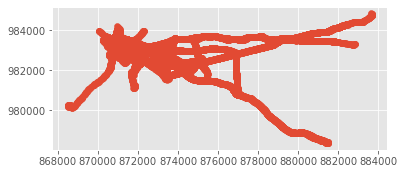

In [7]:
#Se grafican para visualizar que los datos sean coherentes con la malla vial
gdfcar.plot()

In [8]:
#Se crea la columna de angulos
gdfcar['angulo_vel']=0.0

In [9]:
#se toman los atributos para calcular el azimut
for i in range(0, len(gdfcar)-1):
    if  (gdfcar["file"].iloc[i] == gdfcar["file"].iloc[i+1]):#Evita leer coordenadas de rutas diferentes
        #Calcula el azimuth de los puntos
        x1=gdfcar.loc[i,'geometry'].x
        y1=gdfcar.loc[i,'geometry'].y
        x2=gdfcar.loc[i+1,'geometry'].x
        y2=gdfcar.loc[i+1,'geometry'].y
        if (x2 > x1):
            if y2 > y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))
            else:
                ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+90
        else:
            if y2 < y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))+180
            else:
                try:
                    ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+270
                except:
                    ang=0
    else:
        ang=gdfcar.iloc[i-1,-1]                
    gdfcar.loc[i,'angulo_vel']=ang
gdfcar.loc[i+1,'angulo_vel']=ang
gdfcar

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,fecha,t0,tiempo,geometry,angulo_vel
0,EO,3,1010,2.22222,8.00000,2017-06-20 06:38:43,4.45837,-75.12582,2017-06-20,06:00:00,06:38:43,POINT (883647.110 984840.929),170.58524
1,EO,4,966,3.88889,14.00000,2017-06-20 06:38:58,4.45807,-75.12577,2017-06-20,06:00:00,06:38:58,POINT (883652.613 984807.741),171.92208
2,EO,5,946,4.44444,16.00000,2017-06-20 06:39:11,4.45760,-75.12570,2017-06-20,06:00:00,06:39:11,POINT (883659.940 984756.117),184.49619
3,EO,6,937,6.11111,22.00000,2017-06-20 06:39:16,4.45738,-75.12572,2017-06-20,06:00:00,06:39:16,POINT (883658.056 984732.157),212.91184
4,EO,7,935,6.66667,24.00000,2017-06-20 06:39:21,4.45715,-75.12587,2017-06-20,06:00:00,06:39:21,POINT (883641.368 984706.374),232.40697
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22049,OE,662,1148,7.22222,26.00000,2017-06-07 18:37:46,4.43752,-75.20335,2017-06-07,18:00:00,18:37:46,POINT (875037.025 982547.568),351.92749
22050,OE,663,1147,6.11111,22.00000,2017-06-07 18:37:48,4.43763,-75.20337,2017-06-07,18:00:00,18:37:48,POINT (875035.195 982560.475),344.08603
22051,OE,664,1147,5.27778,19.00000,2017-06-07 18:37:50,4.43775,-75.20340,2017-06-07,18:00:00,18:37:50,POINT (875031.514 982573.384),338.21303
22052,OE,665,1147,4.44444,16.00000,2017-06-07 18:37:52,4.43783,-75.20343,2017-06-07,18:00:00,18:37:52,POINT (875027.828 982582.606),348.73665


In [10]:
#Se crea la columna de angulos
velcar['angulo_vel']=0.0

In [11]:
#se toman los atributos para calcular el azimut
for i in range(0, len(velcar)-1):
    if  (velcar["file"].iloc[i] == velcar["file"].iloc[i+1]):#Evita leer coordenadas de rutas diferentes
        #Calcula el azimuth de los puntos
        x1=velcar.loc[i,'geometry'].x
        y1=velcar.loc[i,'geometry'].y
        x2=velcar.loc[i+1,'geometry'].x
        y2=velcar.loc[i+1,'geometry'].y
        if (x2 > x1):
            if y2 > y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))
            else:
                ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+90
        else:
            if y2 < y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))+180
            else:
                try:
                    ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+270
                except:
                    ang=0
    else:
        ang=velcar.iloc[i-1,-1]                
    velcar.loc[i,'angulo_vel']=ang
velcar.loc[i+1,'angulo_vel']=ang
velcar

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,t0,A0,velocity_m,velocity_k,slope,geometry,angulo_vel
0,1,4.43089,-75.24018,1217.72900,11-09-2020,12:25:01,2020-09-11 12:25:01,2020-09-11_07-25_Fri CARRO.gpx,12:25:01,1217.72900,0.00000,0.00000,0.00000,POINT (870947.965 981821.229),232.03510
1,2,4.43089,-75.24017,1217.56100,11-09-2020,12:25:02,2020-09-11 12:25:02,2020-09-11_07-25_Fri CARRO.gpx,12:25:01,1217.72900,0.20794,0.74860,-80.79070,POINT (870947.887 981821.168),348.73925
2,3,4.43089,-75.24018,1217.38900,11-09-2020,12:25:03,2020-09-11 12:25:03,2020-09-11_07-25_Fri CARRO.gpx,12:25:02,1217.56100,0.37441,1.34786,-45.93952,POINT (870947.870 981821.251),349.16510
3,4,4.43090,-75.24018,1217.15000,11-09-2020,12:25:04,2020-09-11 12:25:04,2020-09-11_07-25_Fri CARRO.gpx,12:25:03,1217.38900,0.22149,0.79735,-107.90761,POINT (870947.815 981821.539),20.14082
4,5,4.43090,-75.24017,1216.73100,11-09-2020,12:25:05,2020-09-11 12:25:05,2020-09-11_07-25_Fri CARRO.gpx,12:25:04,1217.15000,0.31335,1.12808,-133.71421,POINT (870947.904 981821.782),34.88383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197482,197711,4.44826,-75.19981,1140.70000,28-06-2021,15:26:07,2021-06-28 15:26:07,2021-06-28_09-32_Mon.gpx,15:26:02,1140.50000,0.11080,0.39889,36.10025,POINT (875431.685 983735.428),24.94208
197483,197712,4.44827,-75.19981,1140.60000,28-06-2021,15:26:12,2021-06-28 15:26:12,2021-06-28_09-32_Mon.gpx,15:26:07,1140.70000,0.14078,0.50682,-14.20617,POINT (875431.719 983735.499),19.20957
197484,197713,4.44827,-75.19981,1140.60000,28-06-2021,15:26:17,2021-06-28 15:26:17,2021-06-28_09-32_Mon.gpx,15:26:12,1140.60000,0.02839,0.10221,0.00000,POINT (875431.825 983735.803),225.19190
197485,197714,4.44826,-75.19981,1140.40000,28-06-2021,15:26:23,2021-06-28 15:26:23,2021-06-28_09-32_Mon.gpx,15:26:17,1140.60000,0.03520,0.12672,-94.69497,POINT (875431.775 983735.754),203.36167


In [12]:
#Se cambia el formato de la hora y fecha
gdfcar["tiempo"] = gdfcar["tiempo"].apply(
    lambda row: 
    row.strftime("%H:%M:%S")
    )
gdfcar["t0"] = gdfcar["t0"].apply(
    lambda row: 
    row.strftime("%H:%M:%S")
    )
gdfcar["timestamp"] = gdfcar["timestamp"].apply(
    lambda row: 
    row.strftime("%Y-%m-%d %H:%M:%S")
    )
gdfcar["fecha"] = gdfcar["fecha"].apply(
    lambda row: 
    row.strftime("%d-%m-%Y")
    )
gdfcar

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,fecha,t0,tiempo,geometry,angulo_vel
0,EO,3,1010,2.22222,8.00000,2017-06-20 06:38:43,4.45837,-75.12582,20-06-2017,06:00:00,06:38:43,POINT (883647.110 984840.929),170.58524
1,EO,4,966,3.88889,14.00000,2017-06-20 06:38:58,4.45807,-75.12577,20-06-2017,06:00:00,06:38:58,POINT (883652.613 984807.741),171.92208
2,EO,5,946,4.44444,16.00000,2017-06-20 06:39:11,4.45760,-75.12570,20-06-2017,06:00:00,06:39:11,POINT (883659.940 984756.117),184.49619
3,EO,6,937,6.11111,22.00000,2017-06-20 06:39:16,4.45738,-75.12572,20-06-2017,06:00:00,06:39:16,POINT (883658.056 984732.157),212.91184
4,EO,7,935,6.66667,24.00000,2017-06-20 06:39:21,4.45715,-75.12587,20-06-2017,06:00:00,06:39:21,POINT (883641.368 984706.374),232.40697
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22049,OE,662,1148,7.22222,26.00000,2017-06-07 18:37:46,4.43752,-75.20335,07-06-2017,18:00:00,18:37:46,POINT (875037.025 982547.568),351.92749
22050,OE,663,1147,6.11111,22.00000,2017-06-07 18:37:48,4.43763,-75.20337,07-06-2017,18:00:00,18:37:48,POINT (875035.195 982560.475),344.08603
22051,OE,664,1147,5.27778,19.00000,2017-06-07 18:37:50,4.43775,-75.20340,07-06-2017,18:00:00,18:37:50,POINT (875031.514 982573.384),338.21303
22052,OE,665,1147,4.44444,16.00000,2017-06-07 18:37:52,4.43783,-75.20343,07-06-2017,18:00:00,18:37:52,POINT (875027.828 982582.606),348.73665


In [13]:
#Se concatenan los datos en un nuevo dataframe para luego ser guardados
carro = pd.concat([gdfcar, velcar], axis = 0)
carro

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,fecha,t0,tiempo,geometry,angulo_vel,A0,slope
0,EO,3,1010.00000,2.22222,8.00000,2017-06-20 06:38:43,4.45837,-75.12582,20-06-2017,06:00:00,06:38:43,POINT (883647.110 984840.929),170.58524,NaN,NaN
1,EO,4,966.00000,3.88889,14.00000,2017-06-20 06:38:58,4.45807,-75.12577,20-06-2017,06:00:00,06:38:58,POINT (883652.613 984807.741),171.92208,NaN,NaN
2,EO,5,946.00000,4.44444,16.00000,2017-06-20 06:39:11,4.45760,-75.12570,20-06-2017,06:00:00,06:39:11,POINT (883659.940 984756.117),184.49619,NaN,NaN
3,EO,6,937.00000,6.11111,22.00000,2017-06-20 06:39:16,4.45738,-75.12572,20-06-2017,06:00:00,06:39:16,POINT (883658.056 984732.157),212.91184,NaN,NaN
4,EO,7,935.00000,6.66667,24.00000,2017-06-20 06:39:21,4.45715,-75.12587,20-06-2017,06:00:00,06:39:21,POINT (883641.368 984706.374),232.40697,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197482,2021-06-28_09-32_Mon.gpx,197711,1140.70000,0.11080,0.39889,2021-06-28 15:26:07,4.44826,-75.19981,28-06-2021,15:26:02,15:26:07,POINT (875431.685 983735.428),24.94208,1140.50000,36.10025
197483,2021-06-28_09-32_Mon.gpx,197712,1140.60000,0.14078,0.50682,2021-06-28 15:26:12,4.44827,-75.19981,28-06-2021,15:26:07,15:26:12,POINT (875431.719 983735.499),19.20957,1140.70000,-14.20617
197484,2021-06-28_09-32_Mon.gpx,197713,1140.60000,0.02839,0.10221,2021-06-28 15:26:17,4.44827,-75.19981,28-06-2021,15:26:12,15:26:17,POINT (875431.825 983735.803),225.19190,1140.60000,0.00000
197485,2021-06-28_09-32_Mon.gpx,197714,1140.40000,0.03520,0.12672,2021-06-28 15:26:23,4.44826,-75.19981,28-06-2021,15:26:17,15:26:23,POINT (875431.775 983735.754),203.36167,1140.60000,-94.69497


In [14]:
#Se eliminan las columnas que puedan tener datos NaN
carro = carro.drop(['A0', 'slope'], axis=1)
carro

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,fecha,t0,tiempo,geometry,angulo_vel
0,EO,3,1010.00000,2.22222,8.00000,2017-06-20 06:38:43,4.45837,-75.12582,20-06-2017,06:00:00,06:38:43,POINT (883647.110 984840.929),170.58524
1,EO,4,966.00000,3.88889,14.00000,2017-06-20 06:38:58,4.45807,-75.12577,20-06-2017,06:00:00,06:38:58,POINT (883652.613 984807.741),171.92208
2,EO,5,946.00000,4.44444,16.00000,2017-06-20 06:39:11,4.45760,-75.12570,20-06-2017,06:00:00,06:39:11,POINT (883659.940 984756.117),184.49619
3,EO,6,937.00000,6.11111,22.00000,2017-06-20 06:39:16,4.45738,-75.12572,20-06-2017,06:00:00,06:39:16,POINT (883658.056 984732.157),212.91184
4,EO,7,935.00000,6.66667,24.00000,2017-06-20 06:39:21,4.45715,-75.12587,20-06-2017,06:00:00,06:39:21,POINT (883641.368 984706.374),232.40697
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197482,2021-06-28_09-32_Mon.gpx,197711,1140.70000,0.11080,0.39889,2021-06-28 15:26:07,4.44826,-75.19981,28-06-2021,15:26:02,15:26:07,POINT (875431.685 983735.428),24.94208
197483,2021-06-28_09-32_Mon.gpx,197712,1140.60000,0.14078,0.50682,2021-06-28 15:26:12,4.44827,-75.19981,28-06-2021,15:26:07,15:26:12,POINT (875431.719 983735.499),19.20957
197484,2021-06-28_09-32_Mon.gpx,197713,1140.60000,0.02839,0.10221,2021-06-28 15:26:17,4.44827,-75.19981,28-06-2021,15:26:12,15:26:17,POINT (875431.825 983735.803),225.19190
197485,2021-06-28_09-32_Mon.gpx,197714,1140.40000,0.03520,0.12672,2021-06-28 15:26:23,4.44826,-75.19981,28-06-2021,15:26:17,15:26:23,POINT (875431.775 983735.754),203.36167


In [15]:
#Se guarda el archivo en la ruta deseada
carro.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes/Carro.shp")

Se continua en el codigo alojado en Outlayer-velocidades_PMMEP